![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 12 - Non-parametric Regression </center>
### <center> Local Polynomial Regression </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/12_NonparametricRegression/MainLocalPolynomialRegression.ipynb)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

### Load the Boston house-prices dataset:

In [3]:
from sklearn.datasets import load_boston

mX, vY = load_boston(return_X_y=True)
mX.shape, vY.shape

C:\Users\oryai\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

((506, 13), (506,))

#### Normalize the data:

In [4]:
mX -= mX.mean(0)
mX /= mX.std (0)

vY -= vY.mean()
vY /= vY.std ()

#### Plot the data:

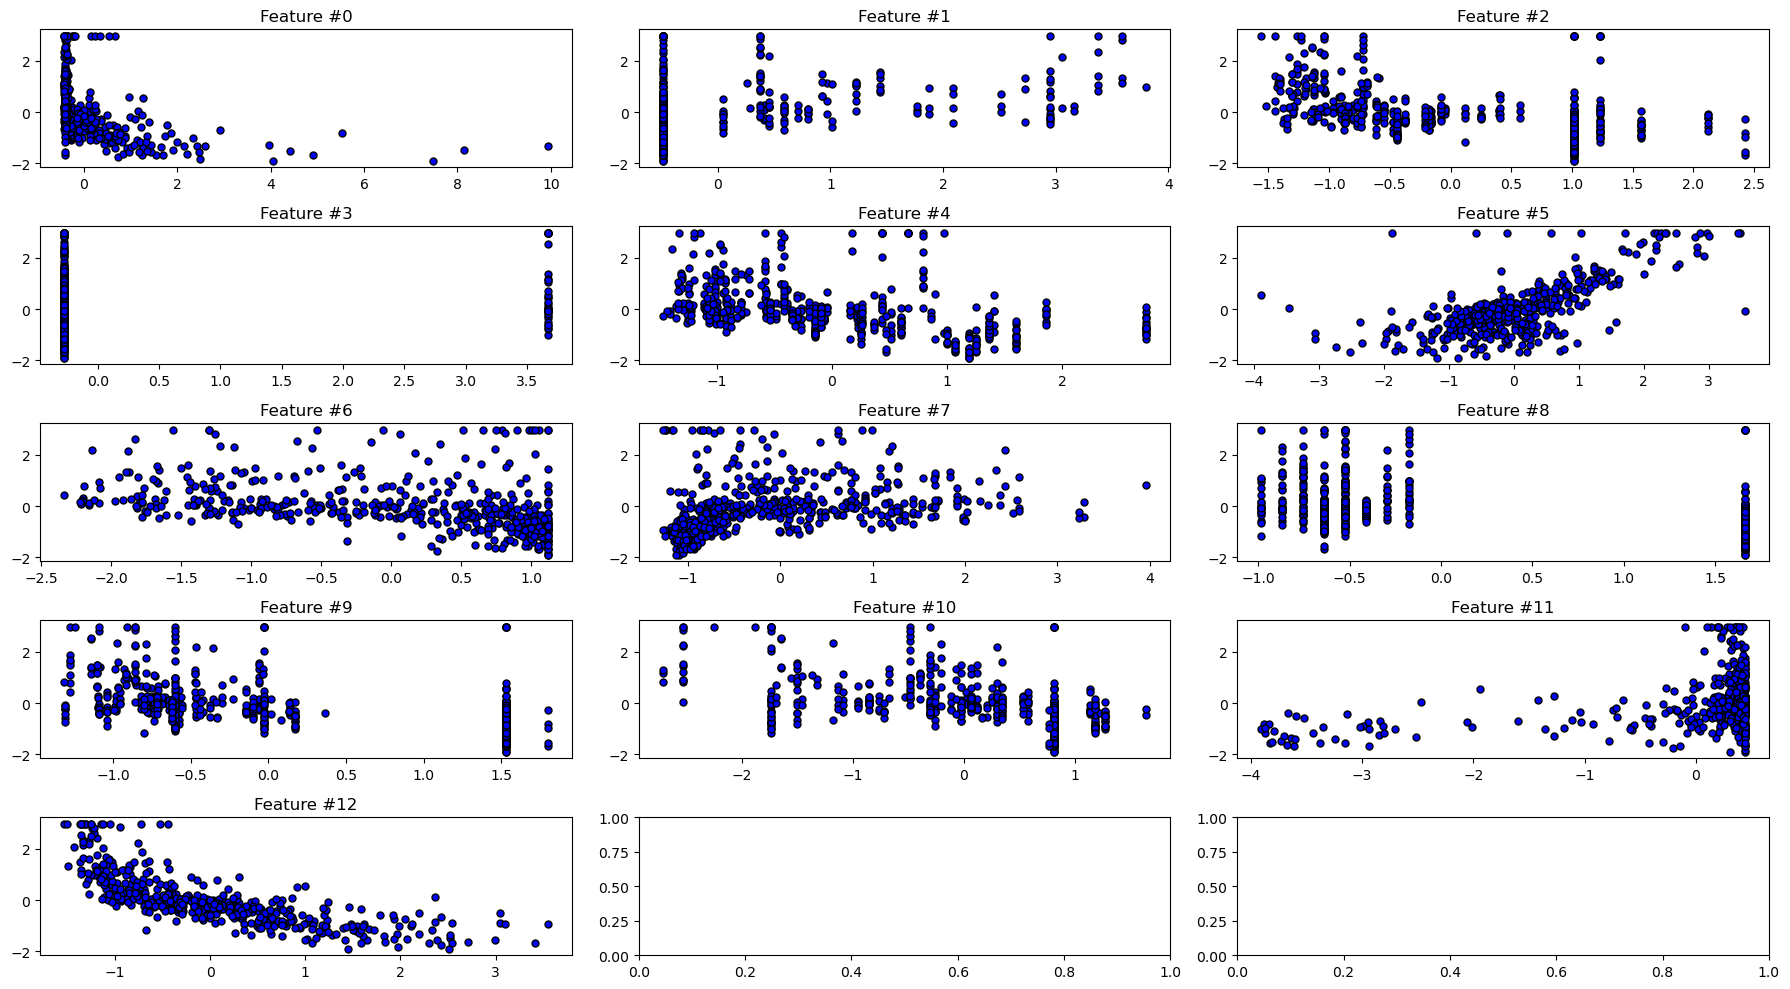

In [5]:
fig, _ = plt.subplots(5, 3, figsize=(18, 10))
for ii, ax in enumerate(fig.axes):
    if ii > 12:
        break
    ax.scatter  (mX[:,ii], vY, s=25, c='b', edgecolor='k')
    ax.set_title(f'Feature #{ii}')

plt.tight_layout()    
plt.show()

#### Simple linear regression:

In [6]:
from sklearn.linear_model import LinearRegression

oLR = LinearRegression().fit(mX, vY)
oLR.score(mX, vY)

0.7406426641094093

#### 2nd order polynomial regression (on the training data):

In [7]:
from sklearn.preprocessing import PolynomialFeatures

mPhi = PolynomialFeatures(degree=2, include_bias=False).fit_transform(mX)
oLR  = LinearRegression().fit(mPhi, vY)
oLR.score(mPhi, vY)

0.9289891941032322

#### Leave one out cross-validation with <u>Pipeline</u>:

In [8]:
from sklearn.pipeline        import make_pipeline
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics         import r2_score

oPolyfit = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
vHatY    = cross_val_predict(oPolyfit, mX, vY, cv=KFold(len(vY), shuffle=True))
scoreLR  = r2_score(vY, vHatY)
scoreLR

0.8466023056986393

### Local polynomial regression (with a Gaussian kernel):
$$\boldsymbol{p}^{\star}=\arg\min_{\boldsymbol{p}\in\mathbb{R}^{P+1}}\sum_{i=1}^{N}w_{i}\left(y_{i}-\boldsymbol{\phi}^{T}\left(x_{i}-x_{0}\right)\boldsymbol{p}\right)^{2}$$
where:
$$w_{i}=k\left(\left\Vert \frac{1}{h}\left(\boldsymbol{x}_{0}-\boldsymbol{x}_{i}\right)\right\Vert _{2}\right)$$
$$k\left(u\right)=e^{-\frac{1}{2}u^{2}}$$

In [9]:
from scipy.spatial.distance import cdist
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing  import FunctionTransformer

#-- Gaussian kernel:
def Kernel(vU):
    return np.exp(-vU**2 / 2)

#-- Estimate f(x₀):
def LocalPolynomialRegression(vX0, mX, vY, h):
    
    #-- Compute u = ||H^-1(x₀ - x_i)||
    vU = cdist(vX0[None], mX, metric='mahalanobis') #-- vU.shape = (1, N)
    vU = vU.squeeze()                               #-- vU.shape = (N,)

    #-- Compute weightes aorund x₀:
    vW  = Kernel(vU / h)
    
    #-- Polyfit (with x_0 subtraction):
    oPolyfit = Pipeline([
        ('Remove x₀',        FunctionTransformer(lambda mX: mX - vX0)         ),
        ('Poly_Features',    PolynomialFeatures (degree=2, include_bias=False)),
        ('LinearRegression', LinearRegression   ()                            )
    ])
    
    #-- Fit & predict:
    oPolyfit.fit(mX, vY, **{'LinearRegression__sample_weight': vW})
    yHat = oPolyfit.predict(vX0[None])

    return yHat

#### Apply model:

In [10]:
N      = len(vY)
K      = 16
vHatY  = np.full(N, np.nan)
vScore = np.full(K, np.nan)

#-- test different h values:
vH = np.linspace(1.7, 3.2, K, endpoint=True)
for kk in range(K):
    h = vH[kk]
    print(f'\r{kk:03d}: h = {h}', end='')
    
    for ii in range(N):
        #-- Leave one out cross-validation:
        mXi       = np.delete(mX, ii, 0)
        vYi       = np.delete(vY, ii)
        vXi       = mX[ii,:]
        vHatY[ii] = LocalPolynomialRegression(vXi, mXi, vYi, h)

    vScore[kk] = r2_score(vY, vHatY)

015: h = 3.2000000000000005

### Plot results:

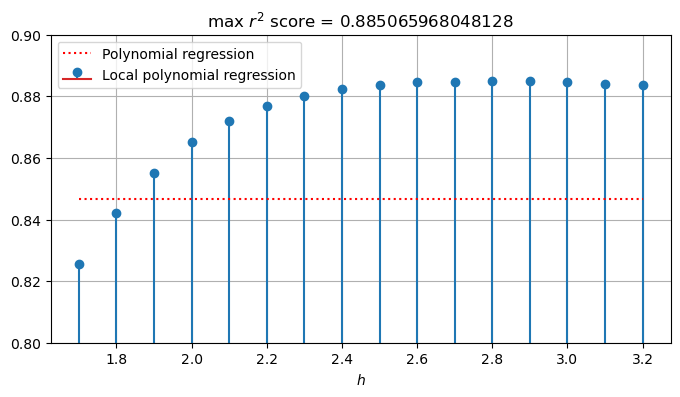

In [11]:
plt.figure(figsize=(8, 4))
plt.stem  (vH,         vScore,                   label='Local polynomial regression')
plt.plot  (vH[[0,-1]], [scoreLR, scoreLR], ':r', label='Polynomial regression')
plt.title (f'max $r^2$ score = {vScore.max()}')
plt.xlabel('$h$')
plt.ylim  ([0.8, 0.9])
plt.legend()
plt.grid  ()
plt.show  ()

### Exercise:
* Use regularization to improve the $R^2$ score.  

**Hint:** when using regularization you can consider a higher polynomial degree.

In [12]:
from sklearn.linear_model  import Lasso
from sklearn.preprocessing import StandardScaler

#-- Gaussian kernel:
def Kernel(vU):
    return np.exp(-vU**2 / 2)

#-- Estimate f(x₀):
def LocalPolynomialRegression2(vX0, mX, vY, h):
    
    #-- Compute u = ||H^-1(x₀ - x_i)||
    vU = cdist(???, ???, metric=???) #-- vU.shape = (1, N)
    vU = vU.squeeze()                #-- vU.shape = (N,)
    
    #-- Compute weightes aorund x₀:
    vW  = Kernel(???)
    
    #-- Lasso (with pipeline):
    oLasso = Pipeline([
        ('Remove x₀',     ???                                             ),
        ('Poly_Features', PolynomialFeatures(degree=???, include_bias=???)),
        ('z_score',       StandardScaler    ()                            ),
        (???,             ???                                              ,
    ])
      
    #-- Fit & predict:
    oLasso.fit(mX, vY, **{'???__sample_weight': vW})
    yHat = oLasso.predict(vX0[None,:])
    
    return yHat

SyntaxError: invalid syntax (<ipython-input-12-3a61f6f1d6a4>, line 12)

### Apply model:

In [ ]:
N      = len(vY)
vHatY  = np.full(N, np.nan)
h      = ???

for ii in range(N):
    #-- Leave one out cross-validation:
    mXi       = np.delete(mX, ii, 0)
    vYi       = np.delete(vY, ii)
    vXi       = mX[ii,:]
    vHatY[ii] = LocalPolynomialRegression2(vXi, mXi, vYi, h)

score = r2_score(vY, vHatY)
score